<a href="https://colab.research.google.com/github/TTobing3/-/blob/main/Steam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

글로벌문화학부 202103083 박은설
글로벌경영학부 201902102 장태규
글로벌문화학부 201903103 이지영

분석의 목적

- 5월 초 기준, 3개월 주차별 최고 인기 게임 100개(판매 수익순)을 보고 시간의 흐름에 따른 장르 빈도수 추이를 추출하여 관찰한다.

관찰 결과를 보며 최근 인기 장르를 발견한다.

- 시계열 데이터에 의해 추출한 데이터를 보고 특정 장르의 인기 게임 100개 속 등장 수를 예측하는 모델을 만든다.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import date


데이터 읽기
-------------------------------------

분석을 위한 데이터: 2024-02 ~ 2024-04 대한민국, 중국, 일본의 주간순위 TOP100 크롤링

In [ ]:
# 데이터 읽기

fileName = 'Steam_Asia_WeeklySellerData.xlsx'
df = pd.read_excel(fileName)

In [ ]:
# 데이터 정보 확인

df.info()
df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3300 non-null   int64 
 1   순위          3300 non-null   int64 
 2   이름          3300 non-null   object
 3   가격          3300 non-null   object
 4   기간          3299 non-null   object
 5   측정 국가       3300 non-null   object
 6   장르          3141 non-null   object
 7   리뷰          3144 non-null   object
 8   출시일         3144 non-null   object
 9   개발사         3144 non-null   object
 10  퍼블리셔        3126 non-null   object
dtypes: int64(2), object(9)
memory usage: 283.7+ KB


,Unnamed: 0,순위,이름,가격,기간,측정 국가,장르,리뷰,출시일,개발사,퍼블리셔
0,0,1,PUBG: BATTLEGROUNDS,0,"For Tue, February 6, 2024 - Tue, February 13, ...","Korea, Republic of","Action,Adventure,Massively Multiplayer,Free to...","Mixed (2,348,376)","21 Dec, 2017","KRAFTON, Inc.","KRAFTON, Inc."


In [ ]:
# 결측치 확인

df.isnull().sum()

Unnamed: 0      0
순위              0
이름              0
가격              0
기간              1
측정 국가           0
장르            159
리뷰            156
출시일           156
개발사           156
퍼블리셔          174
dtype: int64

 다음 분석에서 필요한 칼럼은 순위, 이름, 기간, 장르, 리뷰, 국가이다.

In [ ]:
# 사용하는 칼럼 선택

df_use = df[['순위', '이름', '기간', '장르', '리뷰', '측정 국가']]
df_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3300 entries, 0 to 3299
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   순위      3300 non-null   int64 
 1   이름      3300 non-null   object
 2   기간      3299 non-null   object
 3   장르      3141 non-null   object
 4   리뷰      3144 non-null   object
 5   측정 국가   3300 non-null   object
dtypes: int64(1), object(5)
memory usage: 154.8+ KB


데이터 전처리
--------------------

In [ ]:
# 결측치 제거

df_use = df_use.dropna()
df_use.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3141 entries, 0 to 3298
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   순위      3141 non-null   int64 
 1   이름      3141 non-null   object
 2   기간      3141 non-null   object
 3   장르      3141 non-null   object
 4   리뷰      3141 non-null   object
 5   측정 국가   3141 non-null   object
dtypes: int64(1), object(5)
memory usage: 171.8+ KB


In [ ]:
# 칼럼명 변경

df_use.columns = ['Rank','Title','Term','Genre','Review','Country']
df_use.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3141 entries, 0 to 3298
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Rank     3141 non-null   int64 
 1   Title    3141 non-null   object
 2   Term     3141 non-null   object
 3   Genre    3141 non-null   object
 4   Review   3141 non-null   object
 5   Country  3141 non-null   object
dtypes: int64(1), object(5)
memory usage: 171.8+ KB


데이터를 필요에 맞는 형태로 변환한다.

- Term : 시작일과 종료일로 분리하여 저장
- Genre : ','기준으로 분리하여 list 형식으로 저장
- Review : 리뷰 수 제거 및 카테고리에 포함되지 않는 리뷰 평가 제외


In [ ]:
# 데이터 형변환

import re
from datetime import datetime

# 기간 형변환

def extract_dates(period_str):
    dates = re.findall(r'\w+, \w+ \d{1,2}, \d{4}', period_str)
    if len(dates) == 2:
        start_date = pd.to_datetime(dates[0], format='%a, %B %d, %Y')
        end_date = pd.to_datetime(dates[1], format='%a, %B %d, %Y')
        return start_date, end_date
    return None, None


# 기간 칼럼을 측정 시작일과 측정 종료일로 나누기

df_use['Term_Start'], df_use['Term_End'] = zip(*df_use['Term'].apply(extract_dates))
df_use['Term_Month'] = df_use['Term_Start'].dt.month
df_use.info()
df_use.head(1)

<class 'pandas.core.frame.DataFrame'>
Index: 3141 entries, 0 to 3298
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Rank        3141 non-null   int64         
 1   Title       3141 non-null   object        
 2   Term        3141 non-null   object        
 3   Genre       3141 non-null   object        
 4   Review      3141 non-null   object        
 5   Country     3141 non-null   object        
 6   Term_Start  3141 non-null   datetime64[ns]
 7   Term_End    3141 non-null   datetime64[ns]
 8   Term_Month  3141 non-null   int32         
dtypes: datetime64[ns](2), int32(1), int64(1), object(5)
memory usage: 233.1+ KB


,Rank,Title,Term,Genre,Review,Country,Term_Start,Term_End,Term_Month
0,1,PUBG: BATTLEGROUNDS,"For Tue, February 6, 2024 - Tue, February 13, ...","Action,Adventure,Massively Multiplayer,Free to...","Mixed (2,348,376)","Korea, Republic of",2024-02-06,2024-02-13,2


In [ ]:
# 장르 형변환

df_use['Genre'] = df_use['Genre'].str.split(',')

df_use.info()
df_use.head(1)

<class 'pandas.core.frame.DataFrame'>
Index: 3141 entries, 0 to 3298
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Rank        3141 non-null   int64         
 1   Title       3141 non-null   object        
 2   Term        3141 non-null   object        
 3   Genre       3141 non-null   object        
 4   Review      3141 non-null   object        
 5   Country     3141 non-null   object        
 6   Term_Start  3141 non-null   datetime64[ns]
 7   Term_End    3141 non-null   datetime64[ns]
 8   Term_Month  3141 non-null   int32         
dtypes: datetime64[ns](2), int32(1), int64(1), object(5)
memory usage: 233.1+ KB


,Rank,Title,Term,Genre,Review,Country,Term_Start,Term_End,Term_Month
0,1,PUBG: BATTLEGROUNDS,"For Tue, February 6, 2024 - Tue, February 13, ...","[Action, Adventure, Massively Multiplayer, Fre...","Mixed (2,348,376)","Korea, Republic of",2024-02-06,2024-02-13,2


In [ ]:
# 리뷰 형변환

# 리뷰 항목 리스트

review_categories = [
    "Overwhelmingly Positive", "Very Positive", "Positive", "Mostly Positive",
    "Mixed", "Mostly Negative", "Negative", "Very Negative", "Overwhelmingly Negative"
]

# 리뷰 전처리 함수

def process_review(review_str):
    match = re.match(r'([\w\s]+) \([\d,]+\)', review_str)
    if match:
        review = match.group(1)
        if review in review_categories:
            return review
    return 'Etc'

# 리뷰 데이터 전처리

df_use['Review'] = df_use['Review'].apply(process_review)
df_use.info()
df_use.head()


<class 'pandas.core.frame.DataFrame'>
Index: 3141 entries, 0 to 3298
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Rank        3141 non-null   int64         
 1   Title       3141 non-null   object        
 2   Term        3141 non-null   object        
 3   Genre       3141 non-null   object        
 4   Review      3141 non-null   object        
 5   Country     3141 non-null   object        
 6   Term_Start  3141 non-null   datetime64[ns]
 7   Term_End    3141 non-null   datetime64[ns]
 8   Term_Month  3141 non-null   int32         
dtypes: datetime64[ns](2), int32(1), int64(1), object(5)
memory usage: 233.1+ KB


,Rank,Title,Term,Genre,Review,Country,Term_Start,Term_End,Term_Month
0,1,PUBG: BATTLEGROUNDS,"For Tue, February 6, 2024 - Tue, February 13, ...","[Action, Adventure, Massively Multiplayer, Fre...",Mixed,"Korea, Republic of",2024-02-06,2024-02-13,2
1,2,Palworld,"For Tue, February 6, 2024 - Tue, February 13, ...","[Action, Adventure, Indie, RPG, Early Access]",Very Positive,"Korea, Republic of",2024-02-06,2024-02-13,2
2,3,HELLDIVERS™ 2,"For Tue, February 6, 2024 - Tue, February 13, ...",[Action],Very Positive,"Korea, Republic of",2024-02-06,2024-02-13,2
3,4,TEKKEN 8,"For Tue, February 6, 2024 - Tue, February 13, ...",[Action],Mostly Positive,"Korea, Republic of",2024-02-06,2024-02-13,2
4,5,Lethal Company,"For Tue, February 6, 2024 - Tue, February 13, ...","[Action, Adventure, Indie, Early Access]",Overwhelmingly Positive,"Korea, Republic of",2024-02-06,2024-02-13,2


리뷰 중 "Mostly Negative" 이하 평가는 인기가 없다고 판단하고 제외

In [ ]:

popular_categories = [
    "Overwhelmingly Positive", "Very Positive", "Positive", "Mostly Positive",
    "Mixed"]


In [ ]:
#인기있는 데이터 - 안 좋은 리뷰 제거

df_popular = df_use[df_use['Review'].isin(popular_categories)]

df_popular.info()
df_popular.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2949 entries, 0 to 3298
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Rank        2949 non-null   int64         
 1   Title       2949 non-null   object        
 2   Term        2949 non-null   object        
 3   Genre       2949 non-null   object        
 4   Review      2949 non-null   object        
 5   Country     2949 non-null   object        
 6   Term_Start  2949 non-null   datetime64[ns]
 7   Term_End    2949 non-null   datetime64[ns]
 8   Term_Month  2949 non-null   int32         
dtypes: datetime64[ns](2), int32(1), int64(1), object(5)
memory usage: 218.9+ KB


,Rank,Title,Term,Genre,Review,Country,Term_Start,Term_End,Term_Month
0,1,PUBG: BATTLEGROUNDS,"For Tue, February 6, 2024 - Tue, February 13, ...","[Action, Adventure, Massively Multiplayer, Fre...",Mixed,"Korea, Republic of",2024-02-06,2024-02-13,2
1,2,Palworld,"For Tue, February 6, 2024 - Tue, February 13, ...","[Action, Adventure, Indie, RPG, Early Access]",Very Positive,"Korea, Republic of",2024-02-06,2024-02-13,2
2,3,HELLDIVERS™ 2,"For Tue, February 6, 2024 - Tue, February 13, ...",[Action],Very Positive,"Korea, Republic of",2024-02-06,2024-02-13,2
3,4,TEKKEN 8,"For Tue, February 6, 2024 - Tue, February 13, ...",[Action],Mostly Positive,"Korea, Republic of",2024-02-06,2024-02-13,2
4,5,Lethal Company,"For Tue, February 6, 2024 - Tue, February 13, ...","[Action, Adventure, Indie, Early Access]",Overwhelmingly Positive,"Korea, Republic of",2024-02-06,2024-02-13,2


장르 데이터 프레임 생성

In [ ]:

# 예외 장르
genre_nontarget = [
    'Animation & Modeling', 'Design & Illustration' , 'Early Access', 'Free to Play',
    'Game Development', 'Massively Multiplayer', 'Photo Editing', 'Web Publishing'
]

# 장르 토탈
genre_total = []

for genre_list in df_popular['Genre'] :
    for genre in genre_list :
      if genre not in genre_total  :
        genre_total.append( genre )
print(genre_total)

['Action', 'Adventure', 'Massively Multiplayer', 'Free to Play', 'Indie', 'RPG', 'Early Access', 'Simulation', 'Strategy', 'Casual', 'Sports', 'Racing', 'Animation & Modeling', 'Design & Illustration', 'Game Development', 'Photo Editing', 'Utilities', 'Education', 'Web Publishing']


In [ ]:
# 장르 빈도 데이터 프레임 생성 메서드

def collect_genre(country, date, option):
  global df_popular

  df_genre = pd.DataFrame(columns = ['Genre','Count'])
  df_target = df_popular

  if country != 'All' :
    df_target = df_target.loc[ df_target['Country'] == country ]

  if date != 'All' :
    df_target = df_target.loc[ df_target['Term_Start'] == date ]

  for genre in genre_total :
    df_genre.loc[df_genre['Genre'].sum()] = [ genre, 0 ]

  for genre_list in df_target['Genre'] :
    for genre in genre_list :
        df_genre.loc[df_genre['Genre'] == genre, 'Count'] += 1

  #조건
  if option == 1 : # 예외 장르 제외
    df_genre = df_genre[ df_genre['Genre'].isin(genre_nontarget) == False ]

  df_genre = df_genre.reset_index(drop=True)

  return df_genre


In [ ]:
#전체 장르 등장 빈도수 데이터 프레임 생성
df_genre = collect_genre('All','All',0)

In [ ]:
def draw_GenreFrequencie(df_genre) :
  # 장르 빈도를 기준으로 정렬
  df_genre = df_genre.sort_values('Count', ascending= False)

  radius = 30
  if df_genre.shape[0] > 10 : radius = 90

  # 장르 빈도 시각화
  plt.figure(figsize=(12, 8))
  plt.xticks(rotation=radius, ha='center', fontsize=10)
  plt.title('Genre Frequencies')
  sns.barplot(x='Genre', y='Count', data = df_genre)


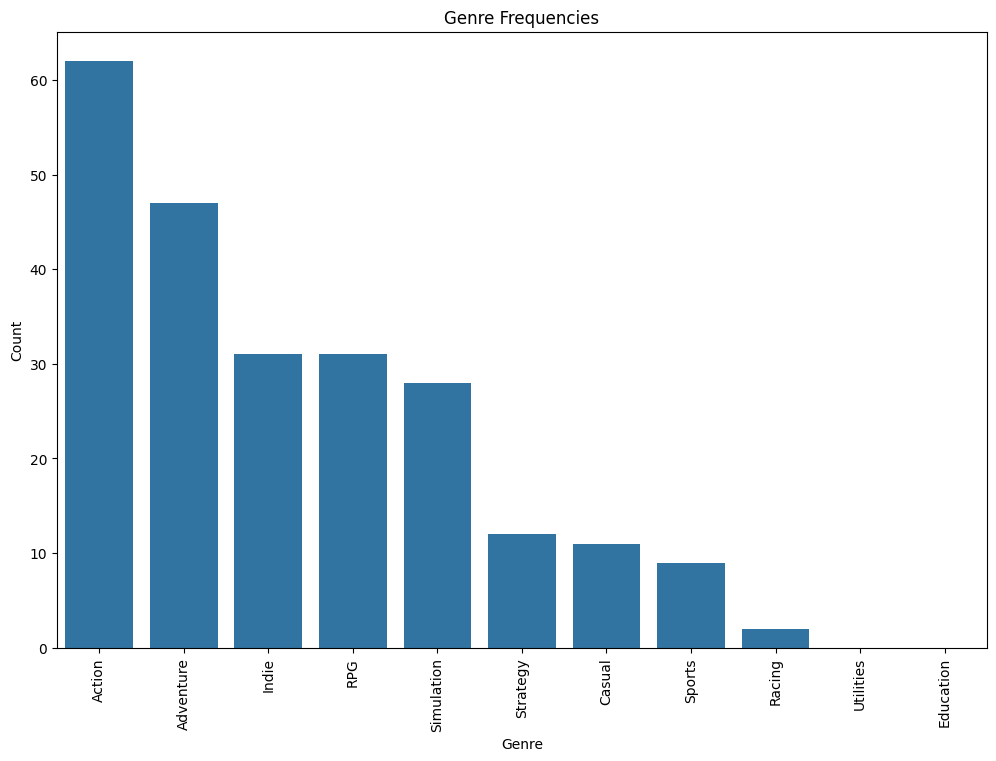

In [ ]:
# 장르 빈도 시각화


draw_GenreFrequencie(df_genre[ df_genre['Genre'].isin(genre_nontarget) == False ])

In [ ]:
# 모든 장르 태그

def draw_GenreFrequenciesOverTime(country, option) :
  global df_popular

  #국가
  if country == 'All' or country == '' or country == None :
    df_exploded = df_popular.explode('Genre')
  else :
    df_exploded = df_popular.loc[ df_popular['Country']== country ].explode('Genre')

  # Term_Start와 Genre를 그룹화하여 빈도수 추이를 그릴 수 있는 데이터 프레임 생성
  df_flow = df_exploded.groupby(['Term_Start', 'Genre']).size().reset_index(name='Count')
  print(df_flow.head())

  #조건
  if option == 1 : # 예외 장르 제외
    df_flow = df_flow[ df_flow['Genre'].isin(genre_nontarget) == False ]


  #시각화
  plt.figure(figsize=(14, 8))
  sns.lineplot(data=df_flow, x='Term_Start', y='Count', hue='Genre', marker='o')
  plt.title('Genre Frequencies Over Time : '+country)
  plt.xlabel('Term Start')
  plt.ylabel('Frequency')
  plt.xticks(rotation=45)
  plt.legend(title='Genre')
  plt.tight_layout()
  plt.show()


  Term_Start                  Genre  Count
0 2024-02-06                 Action    200
1 2024-02-06              Adventure    131
2 2024-02-06   Animation & Modeling      3
3 2024-02-06                 Casual     28
4 2024-02-06  Design & Illustration      3


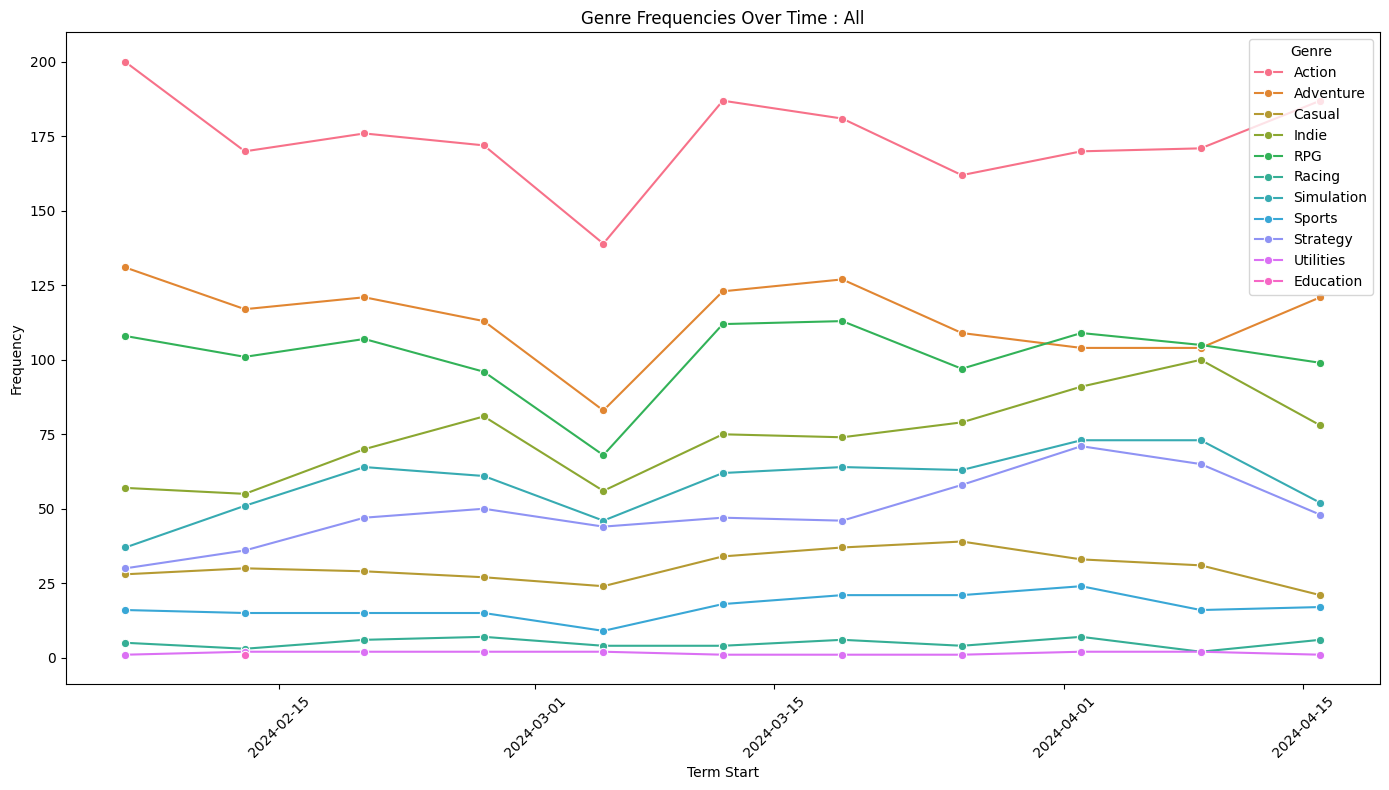

In [ ]:
# 예외 장르 제외 추이

draw_GenreFrequenciesOverTime('All',1)


  Term_Start                  Genre  Count
0 2024-02-06                 Action     69
1 2024-02-06              Adventure     43
2 2024-02-06   Animation & Modeling      1
3 2024-02-06                 Casual     14
4 2024-02-06  Design & Illustration      1


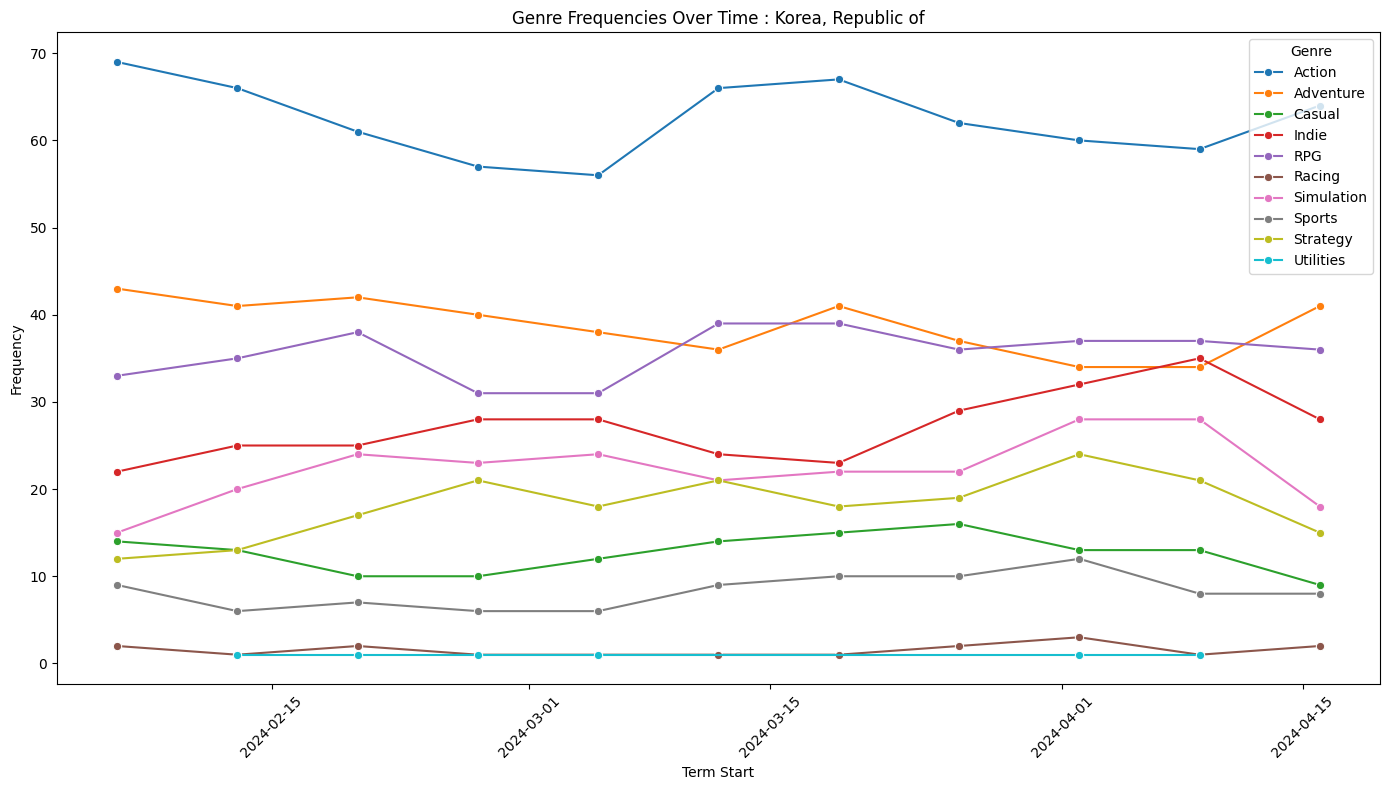

In [ ]:
# 한국, 예외 장르 제외 추이

draw_GenreFrequenciesOverTime('Korea, Republic of',1)

  Term_Start                  Genre  Count
0 2024-02-06                 Action     60
1 2024-02-06              Adventure     39
2 2024-02-06   Animation & Modeling      1
3 2024-02-06                 Casual      6
4 2024-02-06  Design & Illustration      1


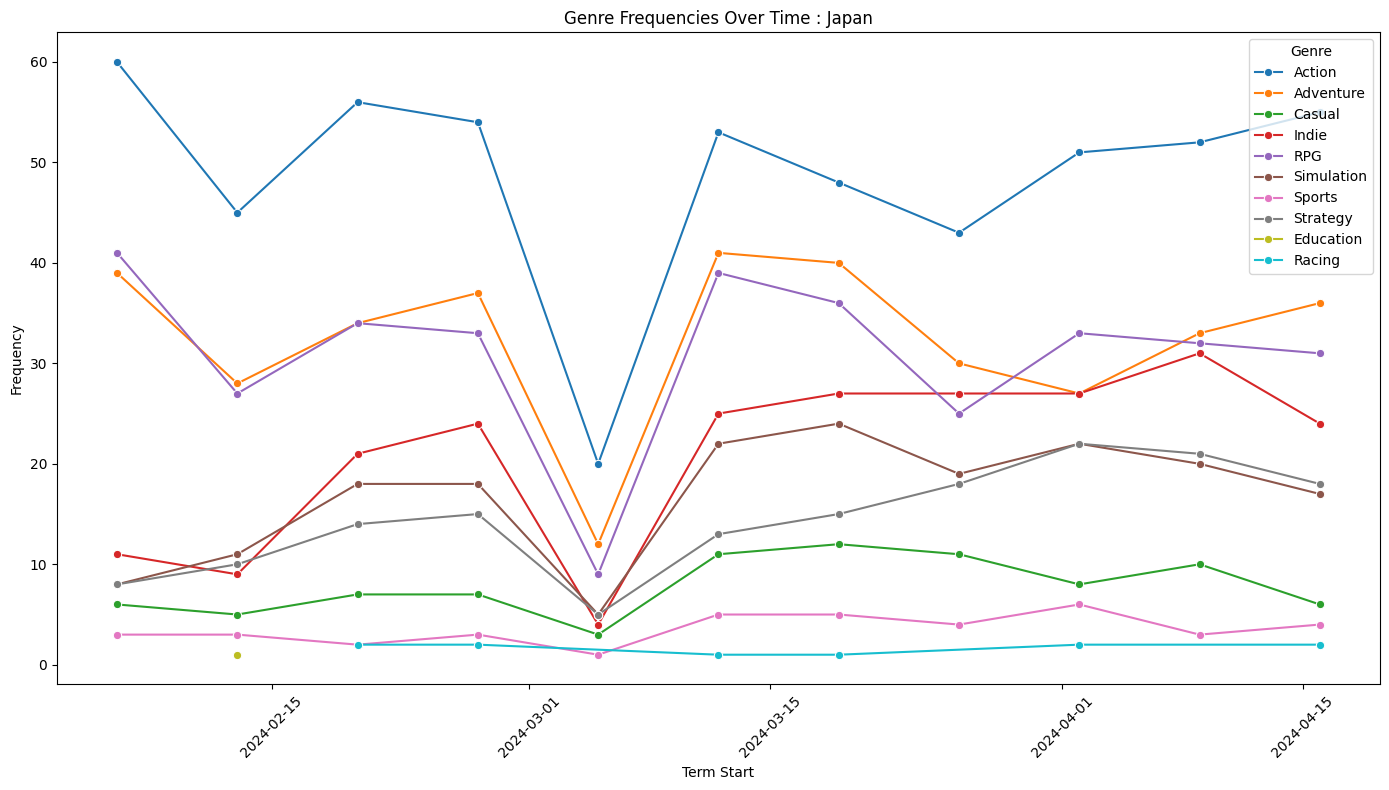

In [ ]:
# 일본, 예외 장르 제외 추이

draw_GenreFrequenciesOverTime('Japan',1)

  Term_Start                  Genre  Count
0 2024-02-06                 Action     71
1 2024-02-06              Adventure     49
2 2024-02-06   Animation & Modeling      1
3 2024-02-06                 Casual      8
4 2024-02-06  Design & Illustration      1


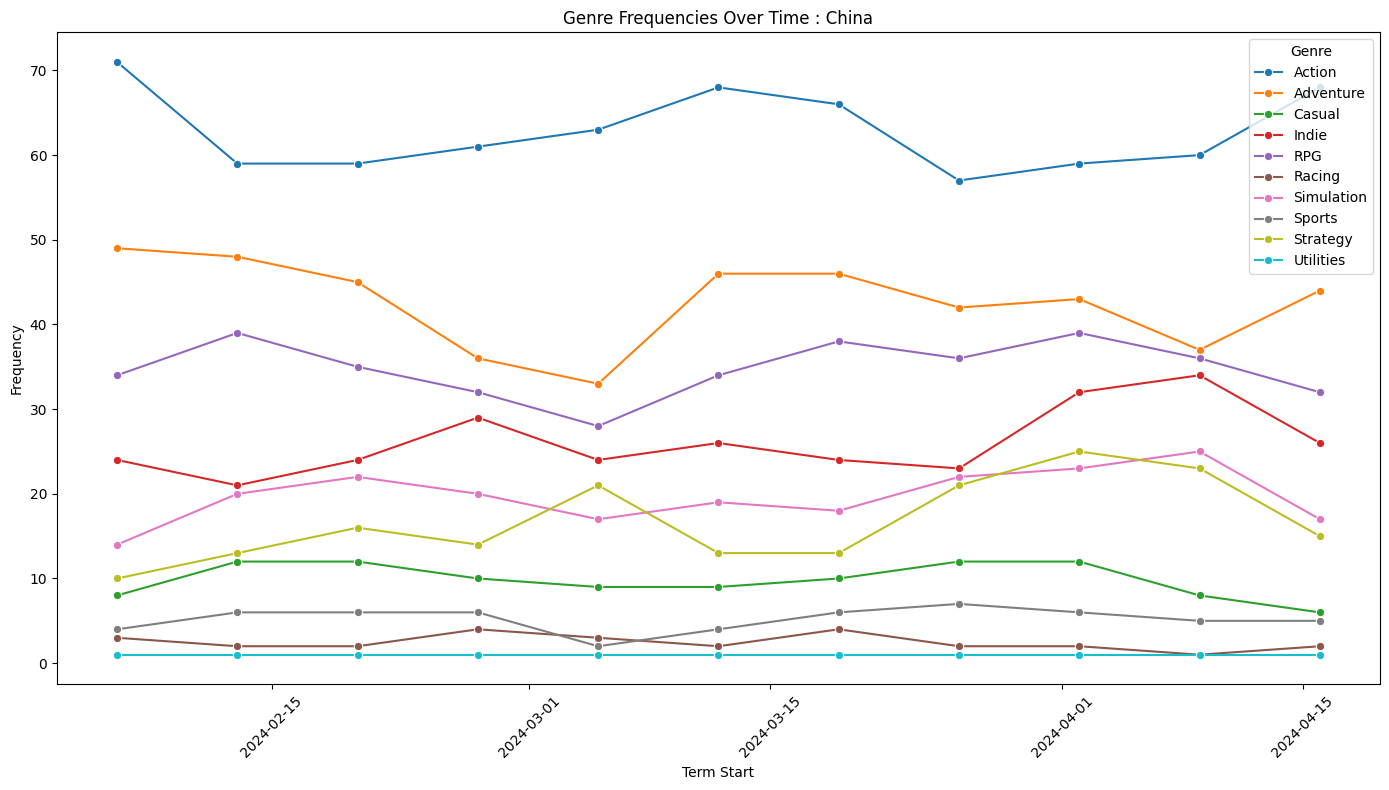

In [ ]:
# 중국, 예외 장르 제외 추이

draw_GenreFrequenciesOverTime('China',1)


In [ ]:
#국가별 장르 개수 비교 함수

def draw_GenreFrequencies_Country(date, option) :

  df_genre_korea = collect_genre('Korea, Republic of', date, option).sort_values('Count', ascending= False)
  df_genre_japan = collect_genre('Japan', date, option).sort_values('Count', ascending= False)
  df_genre_china = collect_genre('China', date, option).sort_values('Count', ascending= False)

  df_genre_korea['Country'] = 'Korea, Republic of'
  df_genre_japan['Country'] = 'Japan'
  df_genre_china['Country'] = 'China'

  #합치기
  genre_counts = pd.concat([df_genre_korea, df_genre_japan, df_genre_china])

  plt.figure(figsize=(14, 7))
  sns.barplot(data=genre_counts, x='Genre', y='Count', hue='Country')
  plt.title('Genre Frequency for Country : '+date.strftime('%Y-%m-%d'))
  plt.xlabel('Genre')
  plt.ylabel('Count')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

In [ ]:

#두 날짜 비교 함수

def draw_GenreFrequencies_Date(country, date_0, date_1, option):

  df_genre_0 = collect_genre(country, date_0, option).sort_values('Count', ascending= False)
  df_genre_1 = collect_genre(country, date_1, option).sort_values('Count', ascending= False)

  df_genre_0['Date'] = date_0
  df_genre_1['Date'] = date_1

  #합치기
  genre_counts = pd.concat([df_genre_0, df_genre_1])

  plt.figure(figsize=(14, 7))
  sns.barplot(data=genre_counts, x='Genre', y='Count', hue='Date')
  plt.title('Genre Frequency for Date : '+ country)
  plt.xlabel('Genre')
  plt.ylabel('Count')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

선형 회귀 분석을 통한 예측 모델
--

In [ ]:
# 기간 목록

term_starts = df_popular['Term_Start'].unique()
print(term_starts)

<DatetimeArray>
['2024-02-06 00:00:00', '2024-02-13 00:00:00', '2024-02-20 00:00:00',
 '2024-02-27 00:00:00', '2024-03-05 00:00:00', '2024-03-12 00:00:00',
 '2024-03-19 00:00:00', '2024-03-26 00:00:00', '2024-04-02 00:00:00',
 '2024-04-09 00:00:00', '2024-04-16 00:00:00']
Length: 11, dtype: datetime64[ns]


In [ ]:
# 라이브러리 임포트

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
#회귀 모델에 사용할 시계열 데이터 생성

def create_linearData(country):

  df_genre_linear = pd.DataFrame()

  for i in genre_total :
    df_genre_linear[i] = None

  df_genre_linear['Date'] = None

  for i in term_starts :
    df_tmp =  (
        collect_genre(country, pd.to_datetime(i) ,0).
        drop('Genre', axis=1).
        rename(columns={'Count':i.strftime('%Y-%m-%d')})
        )
    df_tmp = df_tmp.transpose()
    df_tmp.columns = genre_total
    df_tmp['Date'] = i
    df_genre_linear = pd.concat([ df_genre_linear, df_tmp ])

  return df_genre_linear


In [ ]:
def create_linearModel(df_genre_linear, country):
  # 선형 회귀모델을 통한 머신러닝
  df_genre_linear['Month'] = df_genre_linear['Date'].dt.month
  df_genre_linear['Day'] = df_genre_linear['Date'].dt.day

  x = df_genre_linear[['Month', 'Day']]
  y = df_genre_linear.drop(columns=['Date'])

  x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.3, random_state=0)

  model = LinearRegression()

  model.fit(x_train, y_train)

  # 예측 (테스트 데이터에 대해 예측)
  y_pred = model.predict(x_test)

  # 예측 결과 DataFrame으로 변환
  y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns, index=y_test.index)


  # 시각화를 위해 x_test와 y_test를 다시 결합하여 날짜 정보를 포함
  test_dates = df_genre_linear.loc[x_test.index, 'Date']

  # 시각화
  plt.figure(figsize=(20, 10))

  palette = sns.color_palette("tab10", len(genre_total))

  # 각 장르에 대해 실제 값과 예측 값 비교 그래프 그리기
  c = 0
  for column in y.columns:
    if column == 'Month' or column ==  'Day' : continue
    if column not in genre_nontarget:
      sns.lineplot(x=df_genre_linear['Date'], y=df_genre_linear[column], label=f'{column} (Actual)', marker='o', color=palette[c])
      sns.lineplot(x=test_dates, y=y_pred_df[column], label=f'{column} (Predicted)', linestyle='--', color=palette[c], alpha=0.6)
      c += 1


  plt.xlabel('Date')
  plt.ylabel('Frequency')
  plt.title('Genre Frequency Over Time : '+country)
  plt.legend(loc='best')
  plt.grid(True)
  plt.show()

  return model


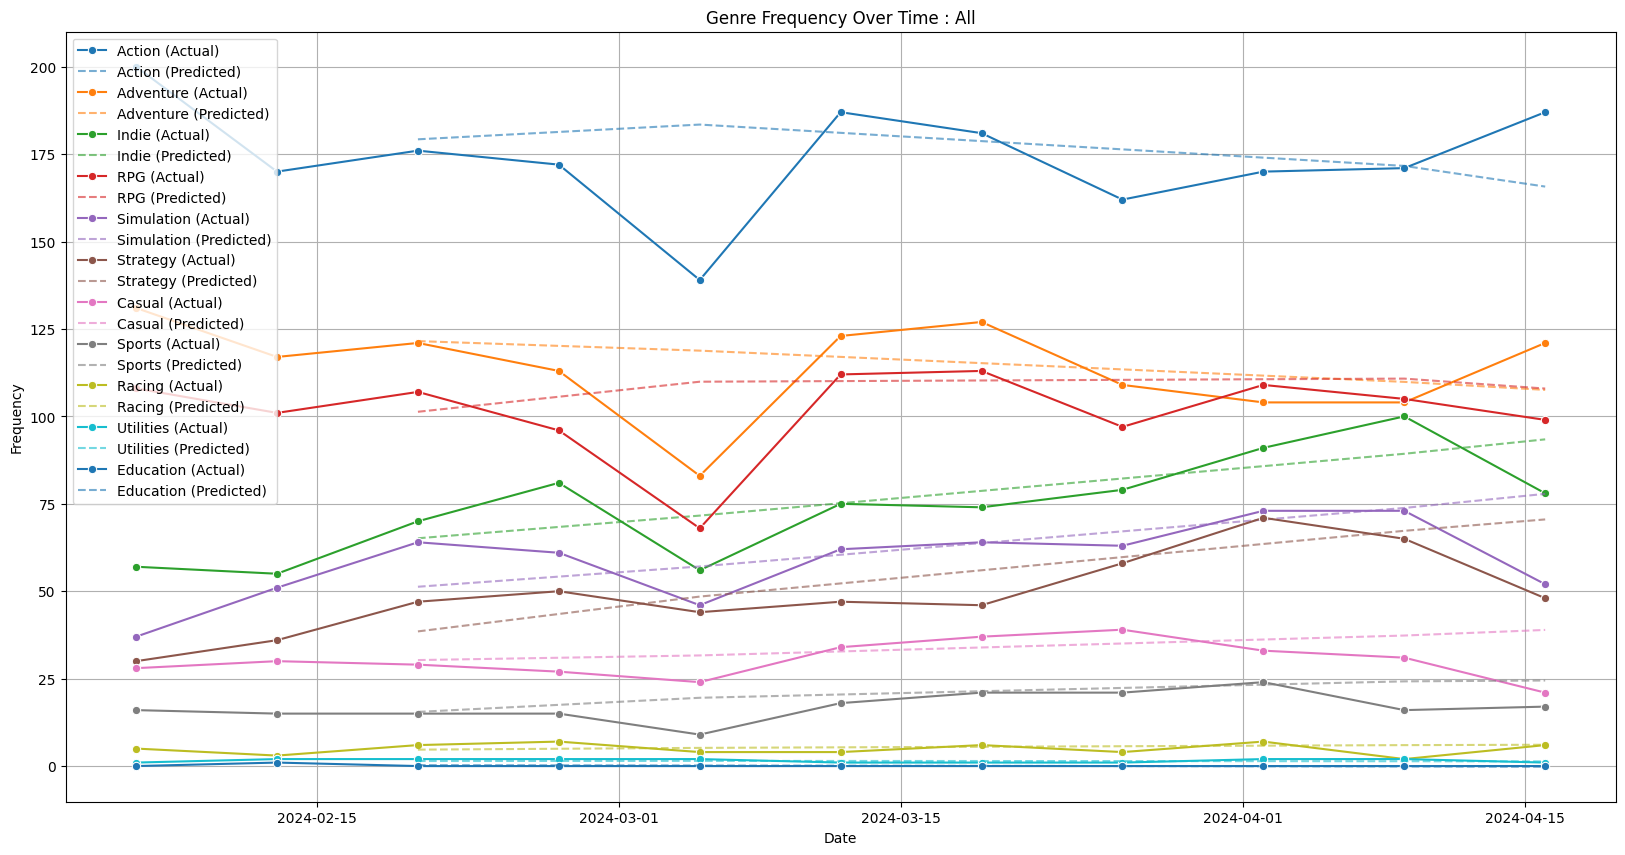

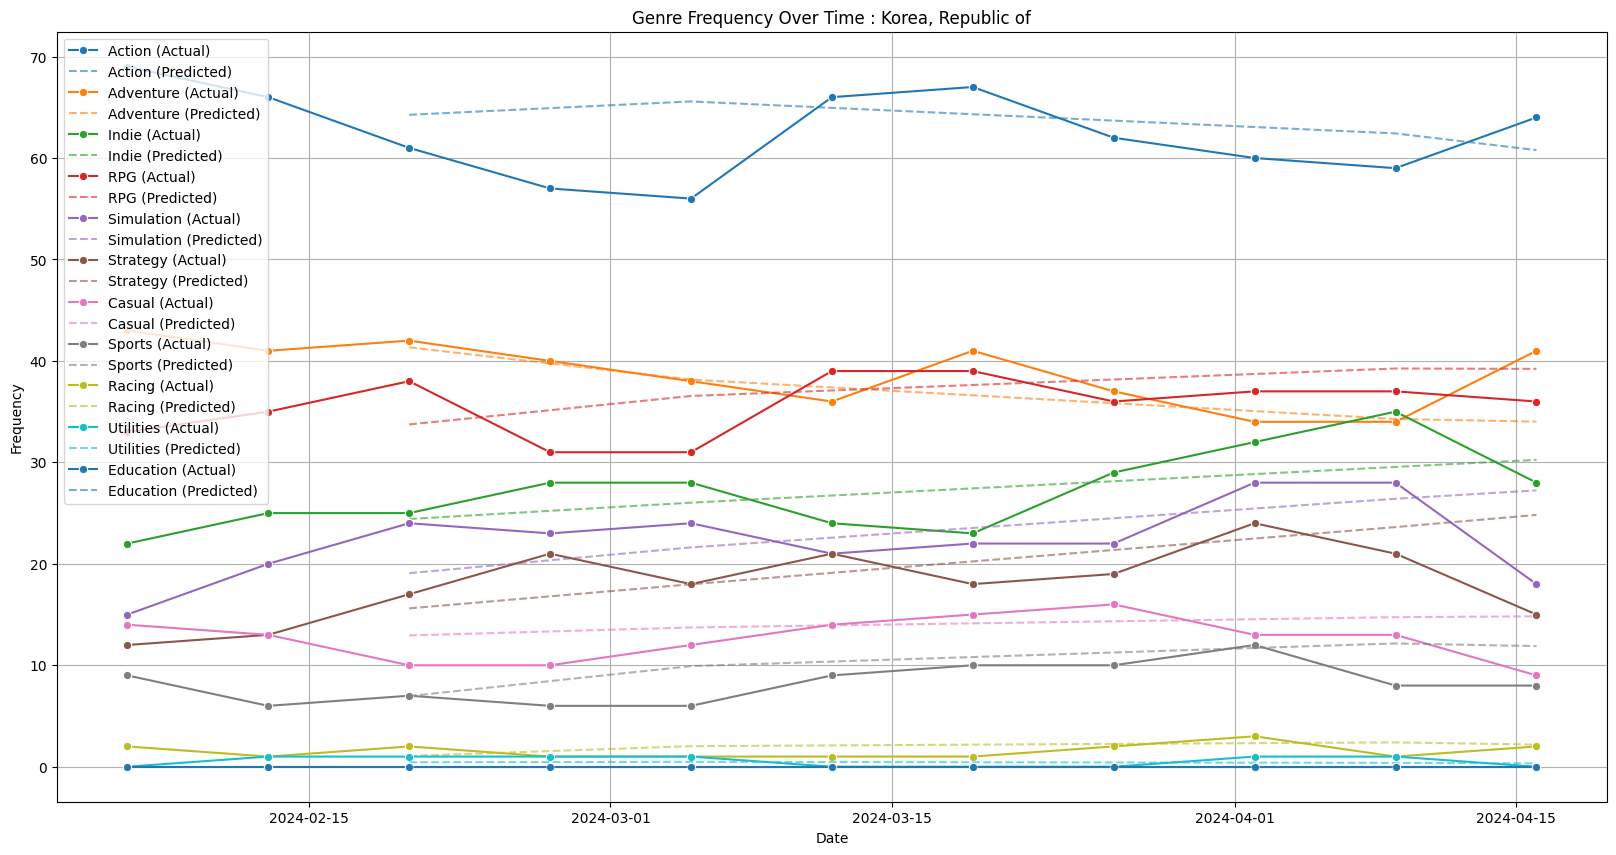

In [ ]:
model_all = create_linearModel(create_linearData('All'), 'All')
model_korea = create_linearModel(create_linearData('Korea, Republic of'), 'Korea, Republic of')

생성한 모델을 통해 예측하기
--

In [ ]:

# 새로운 날짜를 사용하여 각 장르의 빈도수 예측

# 5월 28일 예측
new_date_prediction = model_all.predict([[5, 28]])

# 결과 출력
print("All Predictions for", "05-28")
print("Action:", new_date_prediction[0][0])
print("Adventure:", new_date_prediction[0][1])
print("Indie:", new_date_prediction[0][4])
print("RPG:", new_date_prediction[0][5])

print('\n')


All Predictions for 05-28
Action: 147.14549811708318
Adventure: 96.03543307086613
Indie: 115.82505991098935
RPG: 105.59876754536117




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


예측값과 현재 실제 값 비교

In [ ]:
# 실제 값 가져오기

fileName_add = 'Steam_Korea_May28.xlsx'
df_add = pd.read_excel(fileName_add)

In [ ]:
# 전처리 1

df_use_add = df_add[['순위', '이름', '기간', '장르', '리뷰', '측정 국가']]

df_use_add = df_use_add.dropna()

df_use_add.columns = ['Rank','Title','Term','Genre','Review','Country']


In [ ]:

# 기간 칼럼을 측정 시작일과 측정 종료일로 나누기

df_use_add['Term_Start'], df_use_add['Term_End'] = zip(*df_use_add['Term'].apply(extract_dates))
df_use_add['Term_Month'] = df_use_add['Term_Start'].dt.month


df_use_add['Genre'] = df_use_add['Genre'].str.split(',')

df_use_add['Review'] = df_use_add['Review'].apply(process_review)

df_popular_add = df_use_add[df_use_add['Review'].isin(popular_categories)]

df_genre = pd.DataFrame(columns = ['Genre','Count'])
df_target = df_popular_add

for genre in genre_total :
  df_genre.loc[df_genre['Genre'].sum()] = [ genre, 0 ]

for genre_list in df_target['Genre'] :
  for genre in genre_list :
      df_genre.loc[df_genre['Genre'] == genre, 'Count'] += 1

df_genre = df_genre[ df_genre['Genre'].isin(genre_nontarget) == False ]

df_genre = df_genre.reset_index(drop=True)


In [ ]:

# 한국 5월 28일 예측
new_date_prediction = model_korea.predict([[5, 28]])

# 결과 출력
print("Korea Predictions for", "05-28")
print("   Indie :", new_date_prediction[0][4])
# 실제 결과 출력
print("Korea Actual for", "05-28")
print("   Indie :", df_genre.loc[df_genre['Genre'] == 'Indie']['Count'].to_string(index=False) )

Korea Predictions for 05-28
   Indie : 34.57737076343717
Korea Actual for 05-28
   Indie : 31


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


-------------------------------